In [2]:
pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.8 MB/s eta 0:00:00


+---------+--------------------+---+------+
|PatientID|                Name|Age|Gender|
+---------+--------------------+---+------+
|        1|          John Brown| 65|  Male|
|        2|     Christopher Fox| 45|Female|
|        3|     Jonathan Turner| 25|  Male|
|        4|Mrs. Sylvia Selle...| 44|Female|
|        5|        Scott Fisher| 30|Female|
+---------+--------------------+---+------+
only showing top 5 rows

+---------+---+------------------+------------------+------------------+
|PatientID| BP|             Sugar|       Cholesterol|       Haemoglobin|
+---------+---+------------------+------------------+------------------+
|        1|121|136.85063455715067|192.65866199899915|11.583326735758407|
|        2|164|163.87378541428723| 265.1560586923075|17.050402657270084|
|        3|169| 89.37709403100155|179.12217680820032|14.348120870711494|
|        4|123|202.41336202409653|299.90069267057163|17.128015990041476|
|        5|135|132.66276068536095|296.15509481051566| 16.41761356242

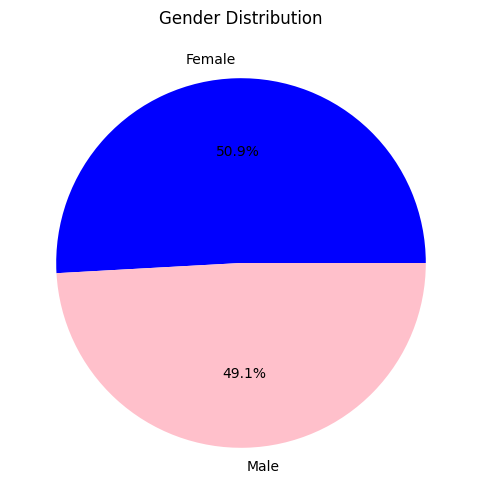

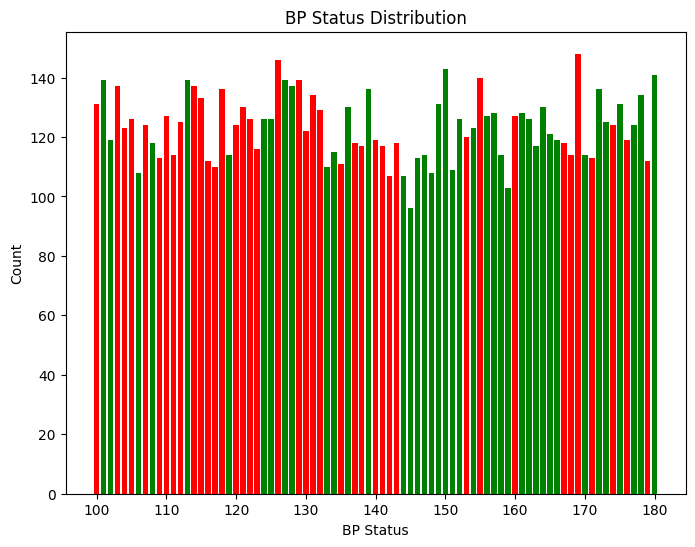

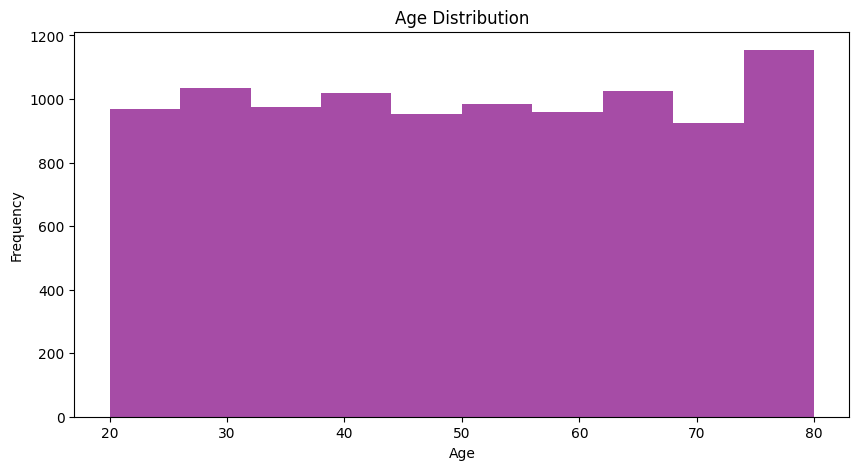

In [ ]:
from faker import Faker
import random
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count
fake = Faker()
spark = SparkSession.builder.appName("HealthMonitoringSystem").getOrCreate()
def generate_patients(n):
    data = [(i, fake.name(), random.randint(20, 80), random.choice(["Male", "Female"])) for i in range(1, n+1)]
    return spark.createDataFrame(data, ["PatientID", "Name", "Age", "Gender"])

patients_df = generate_patients(10000)
patients_df.show(5)
def generate_health_parameters(n):
    data = [(i, random.randint(100, 180), random.uniform(70, 250), random.uniform(100, 300), random.uniform(10, 18))
            for i in range(1, n+1)]
    return spark.createDataFrame(data, ["PatientID", "BP", "Sugar", "Cholesterol", "Haemoglobin"])

health_df = generate_health_parameters(10000)
health_df.show(5)
patients_health_df = patients_df.join(health_df, "PatientID")
patients_health_df.show(5)
def process_bp(bp):
    return "High" if bp > 140 else "Normal"

spark.udf.register("process_bp", process_bp)
patients_health_df = patients_health_df.withColumn("BP_Status", col("BP"))
patients_health_df = patients_health_df.withColumn("BP_Status", col("BP").cast("int"))
stats_df = patients_health_df.select(
    avg("BP").alias("Average_BP"),
    avg("Sugar").alias("Average_Sugar"),
    avg("Cholesterol").alias("Average_Cholesterol"),
    avg("Haemoglobin").alias("Average_Haemoglobin")
)
stats_df.show()
gender_count_df = patients_health_df.groupBy("Gender").agg(count("PatientID").alias("Count"))
gender_count_df.show()

patients_health_df.write.csv("/mnt/data/health_data.csv", mode="overwrite", header=True)

import matplotlib.pyplot as plt
import pandas as pd
gender_pd_df = gender_count_df.toPandas()
plt.figure(figsize=(8, 6))
plt.pie(gender_pd_df["Count"], labels=gender_pd_df["Gender"], autopct="%1.1f%%", colors=['blue', 'pink'])
plt.title("Gender Distribution")
plt.show()

bp_status_df = patients_health_df.groupBy("BP_Status").agg(count("PatientID").alias("Count")).toPandas()
plt.figure(figsize=(8, 6))
plt.bar(bp_status_df["BP_Status"], bp_status_df["Count"], color=['green', 'red'])
plt.title("BP Status Distribution")
plt.xlabel("BP Status")
plt.ylabel("Count")
plt.show()
age_pd_df = patients_health_df.select("Age").toPandas()
plt.figure(figsize=(10, 5))
plt.hist(age_pd_df["Age"], bins=10, color='purple', alpha=0.7)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()
